In [18]:
# 모듈 호출
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
img_size = 224
channel=3

In [ ]:
train_datagen = ImageDataGenerator( 
        rescale=1./255,         # 픽셀 값을 0~1 범위로 변환
        rotation_range=40,      # 40도까지 회전
        width_shift_range=0.2,  # 20%까지 좌우 이동
        height_shift_range=0.2, # 20%까지 상하 이동
        shear_range=0.2,        # 20%까지 기울임
        zoom_range=0.2,         # 20%까지 확대
        horizontal_flip=True,   # 좌우 뒤집기
    )
train_generator = train_datagen.flow_from_directory(
    './dataset/train_10',
    batch_size=50,      
    class_mode='categorical', 
    target_size=(img_size, img_size)) 
valid_datagen = ImageDataGenerator(rescale=1./255) # 스케일링만 진행
valid_generator = valid_datagen.flow_from_directory(
    './dataset/valid_10',
    batch_size=20,      
    class_mode='categorical', 
    target_size=(img_size, img_size))
test_datagen = ImageDataGenerator(rescale=1./255) # 스케일링만 진행
test_generator = test_datagen.flow_from_directory(
    './dataset/test_10',
    batch_size=10,      
    class_mode='categorical', 
    target_size=(img_size, img_size),
    shuffle=False)

Found 10529 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 500 images belonging to 10 classes.


In [ ]:
print('train_generator class : ', train_generator.class_indices)
print('valid_generator class : ', valid_generator.class_indices)
print('test_generator class : ', test_generator.class_indices)

train_generator class :  {'갈아만든배': 0, '레쓰비': 1, '마운틴듀': 2, '밀키스': 3, '스프라이트': 4, '칠성사이다': 5, '코카콜라': 6, '트로피카나망고': 7, '펩시콜라': 8, '환타오렌지': 9}
valid_generator class :  {'갈아만든배': 0, '레쓰비': 1, '마운틴듀': 2, '밀키스': 3, '스프라이트': 4, '칠성사이다': 5, '코카콜라': 6, '트로피카나망고': 7, '펩시콜라': 8, '환타오렌지': 9}
test_generator class :  {'갈아만든배': 0, '레쓰비': 1, '마운틴듀': 2, '밀키스': 3, '스프라이트': 4, '칠성사이다': 5, '코카콜라': 6, '트로피카나망고': 7, '펩시콜라': 8, '환타오렌지': 9}


### 모델 학습하기 - MobileNet
MobileNet_01_acc85.0.h5 파일 load하여 사용
- 은닉층
    * Dense(224, activation='relu')
- 출력층
    * Dense(10, activation='softmax')
- complie
    * optimizer : adam
    * loss : categorical_crossentropy
    * metrics : accuracy

In [ ]:
# 파라미터 설정
classes = len(train_generator.class_indices)
epochs = 300
batch_size = 32

In [ ]:
# 모델 가져오기 - 훈련 이어서 하기
model = load_model('./MobileNet_01_acc85.0.h5')

In [9]:
model_name = './model/MobileNet_02_{epoch:02d}-{val_loss:.4f}.hdf5'
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath = model_name,
                                                 save_weights_only=True, 
                                                 save_freq="epoch")
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

In [11]:
history = model.fit(train_generator,
                    steps_per_epoch=200, 
                    epochs=epochs, 
                    validation_data=valid_generator, 
                    validation_steps=40,
                    callbacks = [[earlystop, cp_callback]]) 

Epoch 1/300
200/200 [==============================] - 398s 2s/step - loss: 0.4864 - accuracy: 0.8385 - val_loss: 0.5791 - val_accuracy: 0.8012
Epoch 2/300
200/200 [==============================] - 146s 732ms/step - loss: 0.4956 - accuracy: 0.8347 - val_loss: 0.5554 - val_accuracy: 0.8112
Epoch 3/300
200/200 [==============================] - 118s 591ms/step - loss: 0.4789 - accuracy: 0.8426 - val_loss: 0.5805 - val_accuracy: 0.7937
Epoch 4/300
200/200 [==============================] - 116s 579ms/step - loss: 0.4800 - accuracy: 0.8398 - val_loss: 0.5778 - val_accuracy: 0.8037
Epoch 5/300
200/200 [==============================] - 115s 575ms/step - loss: 0.4934 - accuracy: 0.8350 - val_loss: 0.5750 - val_accuracy: 0.7987
Epoch 6/300
200/200 [==============================] - 115s 576ms/step - loss: 0.4723 - accuracy: 0.8470 - val_loss: 0.5605 - val_accuracy: 0.8087
Epoch 7/300
200/200 [==============================] - 115s 575ms/step - loss: 0.4831 - accuracy: 0.8408 - val_loss: 0.56

In [12]:
# 모델 저장
accuracy = round(max(history.history['accuracy'])*100,2)
model.save(f'./model/MobileNet_02_model_acc{accuracy}.h5') # 최종 모델 저장

In [13]:
model.evaluate(test_generator)

50/50 [==============================] - 236s 5s/step - loss: 0.5082 - accuracy: 0.8120


[0.508197009563446, 0.8119999766349792]

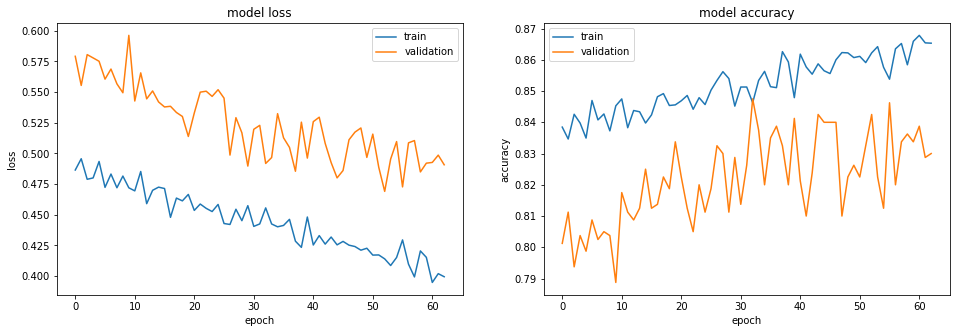

In [14]:
plt.figure(figsize=(16,5))

# 만들어진 모델에 대해 train dataset과 validation dataset의 loss 를 그래프로 표현해 봅니다.
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc=0)

# 만들어진 모델에 대해 train dataset과 validation dataset의 accuracy 를 그래프로 표현해 봅니다.
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc=0)

In [15]:
train_generator.class_indices

{'갈아만든배': 0,
 '레쓰비': 1,
 '마운틴듀': 2,
 '밀키스': 3,
 '스프라이트': 4,
 '칠성사이다': 5,
 '코카콜라': 6,
 '트로피카나망고': 7,
 '펩시콜라': 8,
 '환타오렌지': 9}

In [19]:
test_img = cv2.imread('./Pepsi_cola.jpg')  # 펩시콜라 : 8
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
test_img = cv2.resize(test_img,(224,224))/255.0
test_img = test_img.reshape((1,)+test_img.shape)
model.predict(test_img)

array([[3.3294384e-03, 2.6362916e-04, 2.0264409e-01, 1.6727677e-03,
        7.5279331e-01, 7.1511499e-04, 4.5437426e-03, 5.6303420e-11,
        3.4014057e-02, 2.3776251e-05]], dtype=float32)

In [20]:
test_img = cv2.imread('./fanta_orange.jpg')  # 환타오렌지 : 9
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
test_img = cv2.resize(test_img,(224,224))/255.0
test_img = test_img.reshape((1,)+test_img.shape)
model.predict(test_img)

array([[0.00688446, 0.09320181, 0.25960538, 0.06761499, 0.17126873,
        0.00167747, 0.18287961, 0.04183627, 0.00332389, 0.17170738]],
      dtype=float32)